In [2]:
!pip install torch
!pip install kmeans-pytorch


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
#import os
#from google.colab import drive
#drive.mount('/content/drive')

#os.chdir('/content/drive/MyDrive/advanced_ml_final_project')

In [4]:
import pandas as pd
import numpy as np

#embeddings = pd.read_pickle('/content/drive/MyDrive/advanced_ml_final_project/other_data/clean_2020articles_w_title_embeddings.pkl')
embeddings = pd.read_pickle('clean_2020articles_w_title_embeddings.pkl')

In [5]:
embeddings.rename(columns={"bert_sentence_embedding_title_only": "bert_embeddings"})
embeddings["bert_embeddings"] = embeddings["bert_sentence_embedding_title_only"].apply(lambda x: x.cpu())
embeddings["np_embeddings"] = embeddings["bert_embeddings"].apply(lambda x: x.numpy())
embeddings["normalized_emb"] = embeddings["np_embeddings"].apply(
    lambda x: x/np.linalg.norm(x, keepdims=True))

In [6]:
np_embeddings = np.vstack(embeddings["np_embeddings"])
np_embeddings_norm = np.vstack(embeddings["normalized_emb"])

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score # TODO read about these scoring mechanisms
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def dimension_reduction(embedding, method):
    """
    Performs PCA to reduce dimension of embedding to 
    graph results
    
    Input:
    embedding(np array): embeddings to reduce dimention to
    method(str): method used to calculate embeddings    
    Returns: None, adds a column at for the embeddings dataframe
    """

    pca = PCA(n_components=2, random_state=42)

    pca_vecs = pca.fit_transform(embedding)

    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]

    embeddings[f'x0_{method}'] = x0
    embeddings[f'x1_{method}'] = x1

def plot_pca(x0_name, x1_name, cluster_name, k):
    """
    Plot cluster results for k-clustering in two dimensions
    Inputs:
    -x0_name(str): x variable
    -x1_name(str) y variable
    -cluster_name: The labels of the cluster
    -k(int): Number of cluster
    
    Returns: None, shows figure plotting k-clustering results
    
    """

    plt.figure(figsize=(12, 7))

    plt.title(f"Kmeans clustering with {k} clusters", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})

    sns.scatterplot(data=embeddings, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7efda81ca320>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_v

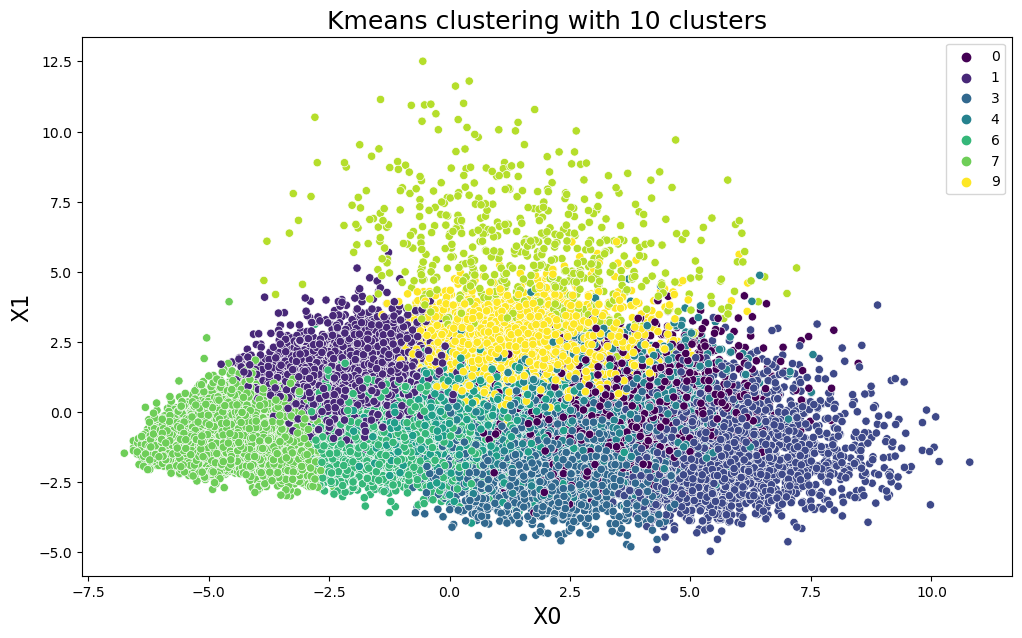

In [8]:
method = 'bert_sentence_title_embedding'
# initialize kmeans with 3 centroids
N_CLUSTERS = 10
kmeans = KMeans(N_CLUSTERS, random_state=42)

# fit the model
kmeans.fit(np_embeddings)

# store cluster labels in a variable
clusters = kmeans.labels_

# Assign clusters to our dataframe
clusters_result_name = f'cluster_bert_embeddings'
embeddings['bert_clusters'] = clusters

#eval_cluster(np_embeddings)

dimension_reduction(np_embeddings, method)

plot_pca(f'x0_{method}', f'x1_{method}', cluster_name=clusters, k=N_CLUSTERS)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

k_values = [10, 20, 50, 100, 250, 500]
avg_silhouette_scores = {}

for k in k_values:
    
    fig, ax = plt.subplots( )
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(np_embeddings) + (k + 1) * 10])
    print("Creating kmeans with {} clusters".format(k))
    kmeans = KMeans(n_clusters=k, random_state=42,max_iter=1000)
    kmeans.fit(np_embeddings)
    clusters = kmeans.labels_
    embeddings[f'cluster_{k}'] = clusters
    silhouette_avg = silhouette_score(np_embeddings, clusters)
    avg_silhouette_scores[k] = silhouette_avg
    sample_silhouette_values = silhouette_samples(np_embeddings, clusters)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette score per cluster")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Clustes")
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


avg scores {}
[0.04490147, 0.01455516, -0.003921329, -0.0014313327, -0.0038726975, -0.0047499873]


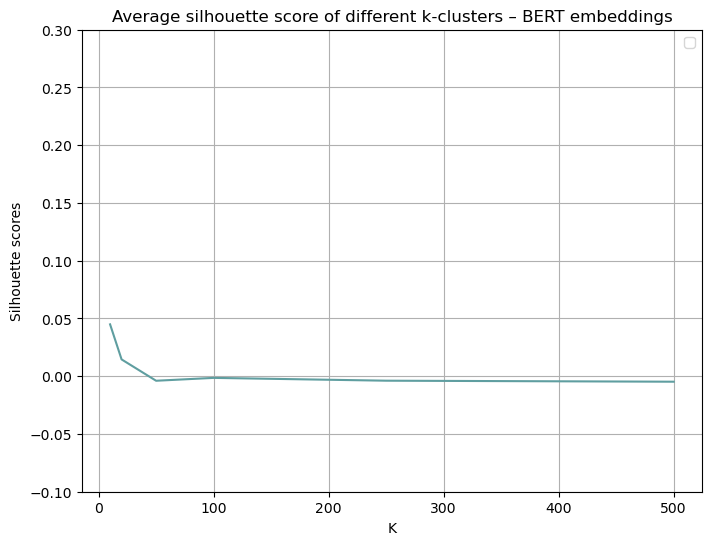

In [18]:
# Plot the average silhouette score for each k for BERT embeddings:
plt.figure(figsize=(8, 6))
print("avg scores",avg_silhoutte_scores)
print(list(avg_silhouette_scores.values()))
silhoutte_scores = list(avg_silhouette_scores.values())

plt.plot(k_values, list(avg_silhouette_scores.values()), color="cadetblue")
ax = plt.gca()             
plt.title('Average silhouette score of different k-clusters – BERT embeddings')
plt.xlabel('K')
plt.ylabel('Silhouette scores')
ax.set_ylim([-0.1, 0.3])
plt.legend()
plt.grid(True)
plt.show()

In [20]:
#Count number of observations per cluster
count_cluster = {}
for k in k_vals:
    k_cluster = f"count_cluster_k{k}"
    count_cluster[k_cluster] = embeddings.groupby(f"cluster_{k}").count().sort_values(by="title", ascending=False)["title"]

In [ ]:
#Agregate text by cluster
doc_per_topic_k10 = embeddings.groupby("cluster_10",as_index=False).agg({"title": " ".join})
doc_per_topic_k50 = embeddings.groupby("cluster_50",as_index=False).agg({"title": " ".join})
doc_per_topic_k100 = embeddings.groupby("cluster_100",as_index=False).agg({"title": " ".join})
doc_per_topic_k200 = embeddings.groupby("cluster_250",as_index=False).agg({"title": " ".join})
doc_per_topic_k500 = embeddings.groupby("cluster_500",as_index=False).agg({"title": " ".join})

In [26]:
doc_per_topic_k10

,cluster_10,title
0,0,court sides with catholic school that let empl...
1,1,‘zuck bucks 2.0’: liberal group uses legal ‘ma...
2,2,"trump slams relief bill, calls on congress to ..."
3,3,us forces rescue american citizen held hostage...
4,4,west virginia gov. jim justice endorses trump ...
5,5,covid select subcommittee subpoenas co-author ...
6,6,blue state ag backs down from targeting religi...
7,7,"trump shifts tone, says he’s ‘proud’ of fed am..."
8,8,trump says he wanted to assassinate syrian pre...
9,9,"iran paid bounties for targeting us troops, in..."


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count


In [24]:
def extract_top_n_words_per_topic(tf_idf, count, doc_per_topic,k_cluster, n=20):
    words = count.get_feature_names_out()
    labels = list(doc_per_topic[k_cluster])
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

In [25]:
tf_idf_10, count_10 = c_tf_idf(doc_per_topic_k10["title"], m=len(embeddings))
top_n_words_10 = extract_top_n_words_per_topic(tf_idf_10, count_10, doc_per_topic_k10,"cluster_10", n=20)
top_n_words_10

{0: [('coronavirus', 0.04196937496171461),
  ('trump', 0.030100679034982765),
  ('court', 0.019461680291823415),
  ('police', 0.01871805541621556),
  ('says', 0.017620187408355185),
  ('illegal', 0.017567234403249393),
  ('new', 0.016126288523442407),
  ('donald', 0.014165594275331279),
  ('house', 0.013900493259910216),
  ('supreme', 0.013722389738882743),
  ('china', 0.013658300882538306),
  ('state', 0.013139617565973732),
  ('case', 0.012438801217305348),
  ('white', 0.012336420255985327),
  ('covid', 0.01220405856228572),
  ('california', 0.011553052695808847),
  ('pandemic', 0.011553052695808847),
  ('report', 0.011314389677796733),
  ('alien', 0.011118104777829018),
  ('iran', 0.011074541570540664)],
 1: [('biden', 0.04180618826750467),
  ('trump', 0.038421729366893594),
  ('joe', 0.02100481198317728),
  ('gop', 0.0197766517953074),
  ('coronavirus', 0.01909959797653639),
  ('says', 0.01771726038758629),
  ('pelosi', 0.01677370188067885),
  ('rep', 0.016528473921087167),
  ('peo

In [41]:
doc_per_topic_k20 = embeddings.groupby("cluster_20",as_index=False).agg({"title": " ".join})
tf_idf_20, count_20 = c_tf_idf(doc_per_topic_k20["title"], m=len(embeddings))
top_n_words_20 = extract_top_n_words_per_topic(tf_idf_20, count_20, doc_per_topic_k20,"cluster_20", n=20)
top_n_words_20

{0: [('coronavirus', 0.057409898250916185),
  ('gov', 0.04209365452070195),
  ('trump', 0.03333291568091378),
  ('new', 0.03099072473330614),
  ('announces', 0.030862371520539895),
  ('signs', 0.02709061669610491),
  ('police', 0.021197466052107813),
  ('order', 0.020677451174503723),
  ('governor', 0.019866328039498494),
  ('state', 0.019370239673463904),
  ('000', 0.019140176629122613),
  ('donald', 0.018552900655892844),
  ('house', 0.01639225139988381),
  ('national', 0.016284017106911283),
  ('ban', 0.015708449837570124),
  ('orders', 0.015123472893535798),
  ('california', 0.015042727404944802),
  ('york', 0.014616237940080372),
  ('cancels', 0.014052140717856917),
  ('emergency', 0.013748545479977706)],
 1: [('trump', 0.049706861238260514),
  ('biden', 0.035366027810911985),
  ('says', 0.029851165764692537),
  ('joe', 0.02051890225558423),
  ('coronavirus', 0.019940323938246077),
  ('democrats', 0.018244418050797913),
  ('donald', 0.017580804493091944),
  ('election', 0.01581713

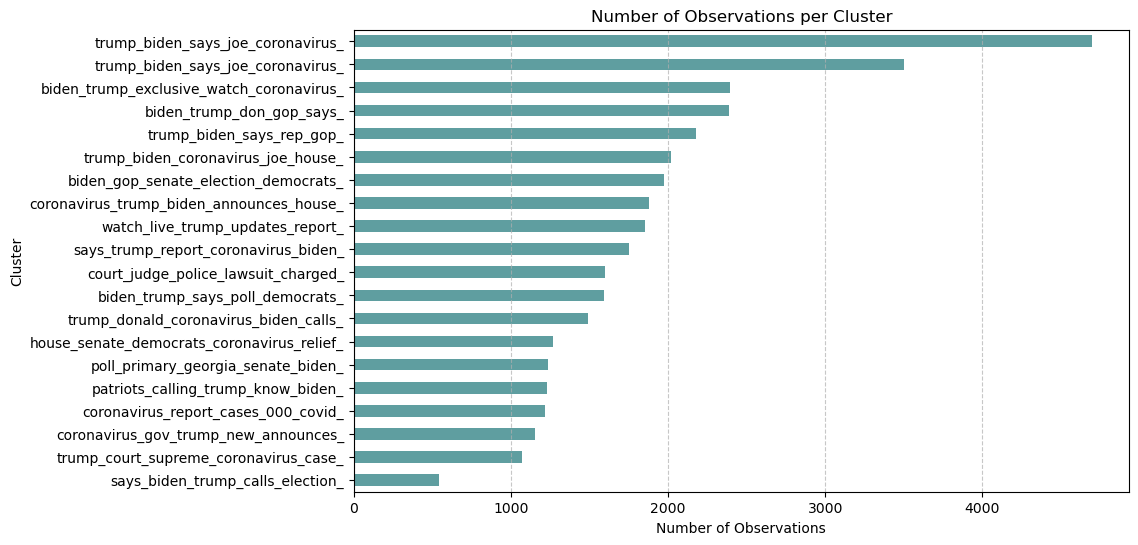

In [46]:
# Count the number of observations per cluster

def cluster_word_rep(k=10):
    """
    Plot the for the first 10 clusters ordered by number of articles
    the number of articles in that cluster with the labels 
    representing the most important words calculated by tf-idf method.
    Input:
    -k(int): Indicator of which cluster label utilized
    Return:
    None, plots graph with results
    """
    cluster_counts = embeddings[f"cluster_{k}"].value_counts()
    labels = {}
    for cluster,n_grams in top_n_words_20.items():
        label = ""
        for word,value in n_grams[:5]:
            label += word
            label += "_"
        labels[cluster] = label

    # Sort the clusters by count
    cluster_counts = cluster_counts.sort_values()

    # Create a horizontal bar plot
    plt.figure(figsize=(10, 6))
    cluster_counts.plot(kind='barh', color='cadetblue')
    plt.xlabel('Number of Observations')
    plt.ylabel('Cluster')
    plt.title('Number of Observations per Cluster')
    plt.yticks(range(len(cluster_counts)), [labels[cluster] for cluster in cluster_counts.index])
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()
cluster_word_rep(20)

In [ ]:
tf_idf_100, count_100 = c_tf_idf(doc_per_topic_k100["title"], m=len(embeddings))
top_n_words_100 = extract_top_n_words_per_topic(tf_idf_100, count_100, doc_per_topic_k100,"cluster_100", n=20)
print("1st cluster:",top_n_words_100[86][:10])
print("2nd cluster:",top_n_words_100[25][:10])
print("3rd cluster:",top_n_words_100[61][:10])
print("4th cluster:",top_n_words_100[46][:10])
print("5th cluster:",top_n_words_100[72][:10])

embeddings[embeddings.cluster_100==86]["title"]


In [ ]:
import itertools
for row in embeddings[embeddings.cluster_100==86][:100].itertuples():
    print(row.title)

In [ ]:
tf_idf_200, count_200 = c_tf_idf(doc_per_topic_k200["title"], m=len(embeddings))
top_n_words_200 = extract_top_n_words_per_topic(tf_idf_200, count_200, doc_per_topic_k200,"cluster_200", n=20)

In [ ]:
count_clusters_k200

In [ ]:
print(top_n_words_200[9])
print(top_n_words_200[151])
print(top_n_words_200[34])

for row in embeddings[embeddings.cluster_200==9][:20].itertuples():
    print(row.title)

In [ ]:
tf_idf_500, count_500 = c_tf_idf(doc_per_topic_k500["title"], m=len(embeddings))
top_n_words_500 = extract_top_n_words_per_topic(tf_idf_500, count_500, doc_per_topic_k500,"cluster_500", n=20)
count_clusters_k500

In [ ]:
print("First cluster: top 20 words",top_n_words_500[129])
print("-"*46)
print("Second cluster: top 20 words",top_n_words_500[88])
print("-"*46)
print("Third cluster: top 20 words",top_n_words_500[310])
print("-"*46)
print("First 20 titles of 1st cluster")
for row in embeddings[embeddings.cluster_500==129][:20].itertuples():
    print(row.title)

print("-"*46)
print("First 20 titles of 2nd cluster")
for row in embeddings[embeddings.cluster_500==88][:20].itertuples():
    print(row.title)
print("-"*46)

In [47]:
#####K-means - TF-IDF embeddings

import nltk
import re
import numpy as np
nltk.download('stopwords')
nltk.download('punkt')

#stop_words = nltk.corpus.stopwords.words('english')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
stop_words = nltk.corpus.stopwords.words('english')
stop_list = ["report","2020"]
stop_words.extend(stop_list)

def remove_stop_words(doc):
    """
    Remove stop words for a document
    Input:
    doc(str): document to apply remove stop words
    Return:
    doc(str): document without the stop words
    """
    # lower case and remove special characters\whitespaces
    tokens = nltk.word_tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(remove_stop_words)

title_corpus = normalize_corpus(list(embeddings["title"]))

cv = CountVectorizer(ngram_range=(1, 1), min_df=0.001, max_df=0.99)
cv_matrix = cv.fit_transform(title_corpus)
cv_matrix.shape

(37044, 1695)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7efcea1ef520>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_v

Creating kmeans with 10 clusters


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7efcea1edcf0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7efcd5b485e0>
Traceb

Creating kmeans with 20 clusters


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7efce9fae5f0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7efce9fae560>
Traceb

Creating kmeans with 100 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7efce9fadcf0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_v

Creating kmeans with 250 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7efce9fadcf0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_v

Creating kmeans with 500 clusters


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7efce5681a20>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/opt/conda/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_v

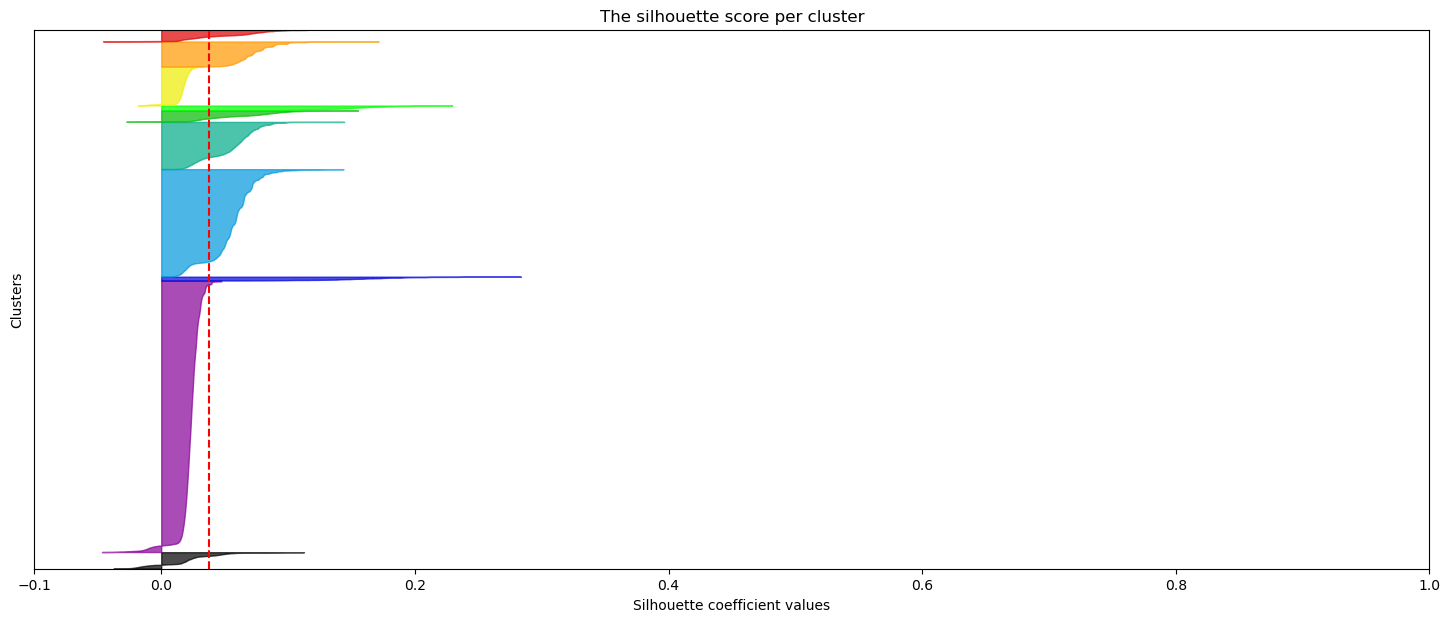

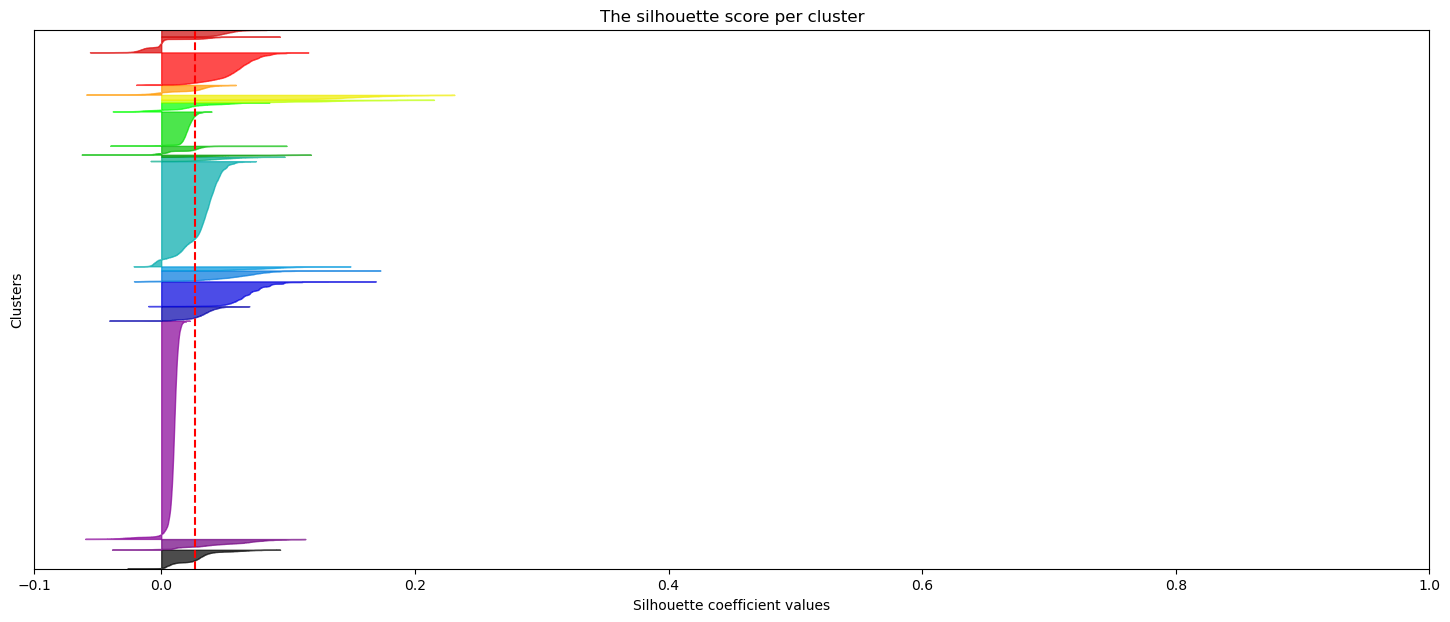

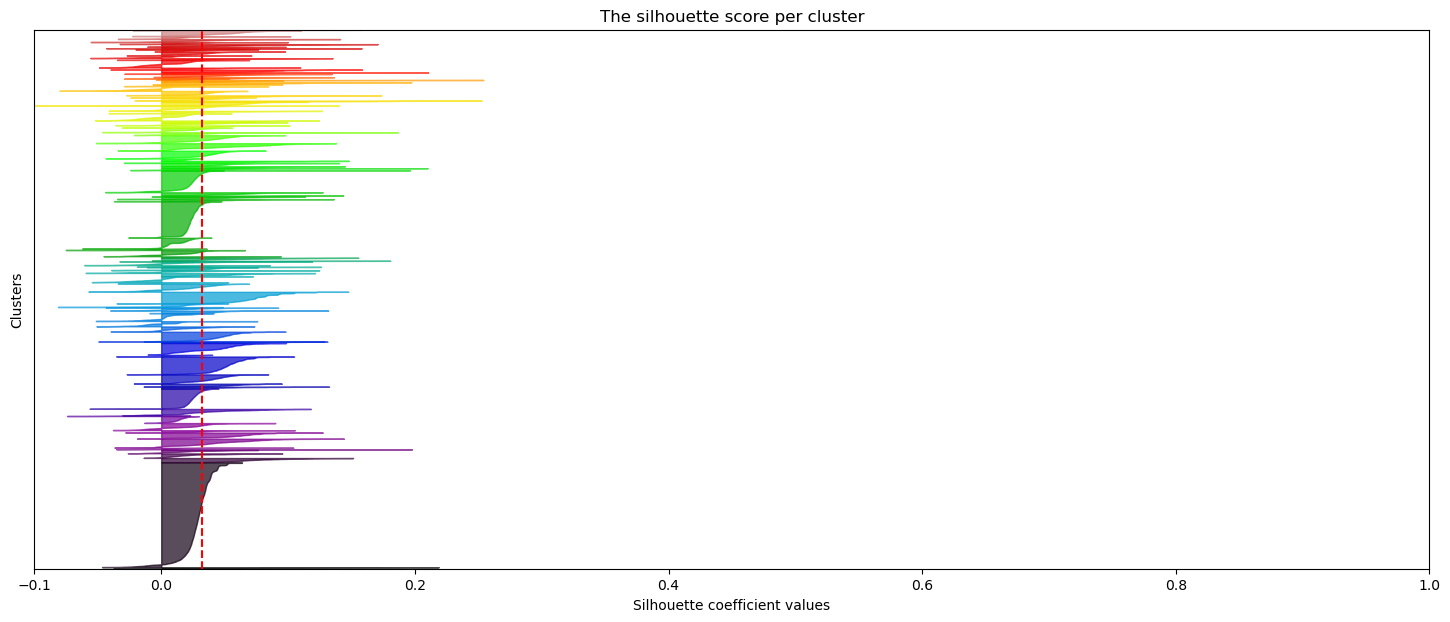

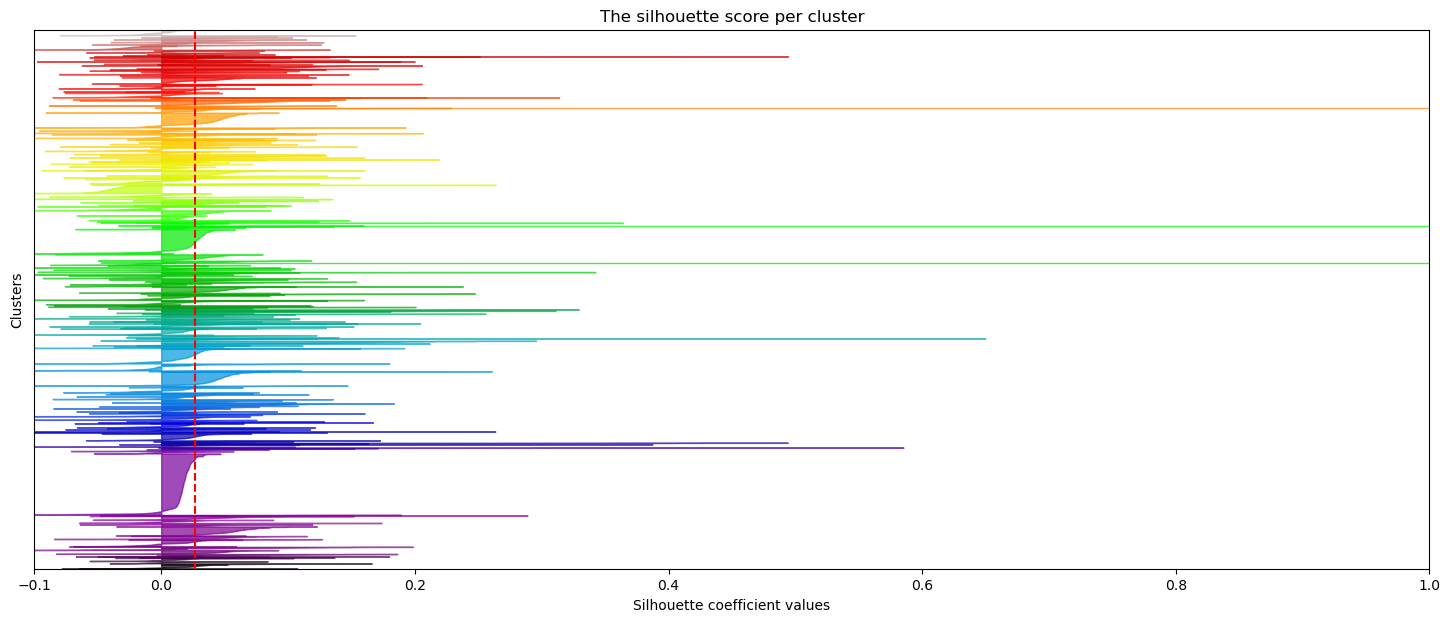

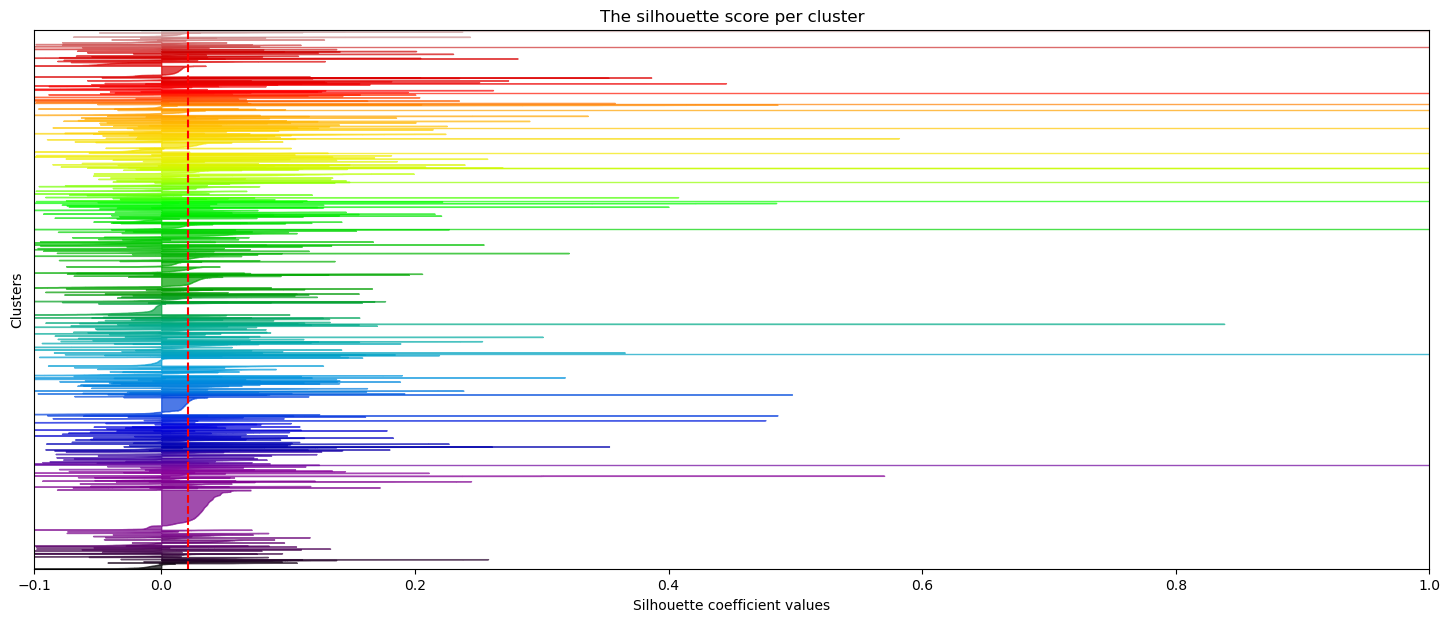

In [54]:
k_values = [10,20,100,250,500]
avg_silhouette_scores = {}

for k in k_values:
    print("Creating kmeans with {} clusters".format(k))
    fig, ax = plt.subplots( )
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax.set_ylim([0, len(np_embeddings) + (k + 1) * 10])
    
    kmeans = KMeans(n_clusters=k, random_state=42,max_iter=1000)
    kmeans.fit(cv_matrix)
    clusters = kmeans.labels_
    embeddings[f'cluster_tf_{k}'] = clusters
    silhouette_avg = silhouette_score(cv_matrix, clusters)
    avg_silhouette_scores[k] = silhouette_avg
    sample_silhouette_values = silhouette_samples(cv_matrix, clusters)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("The silhouette score per cluster")
    ax.set_xlabel("Silhouette coefficient values")
    ax.set_ylabel("Clusters")
    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


avg scores {10: 0.0377494695322175, 20: 0.026918430921443092, 100: 0.031986796353926636, 250: 0.026880206212232475, 500: 0.02127741806798237}
[0.0377494695322175, 0.026918430921443092, 0.031986796353926636, 0.026880206212232475, 0.02127741806798237]


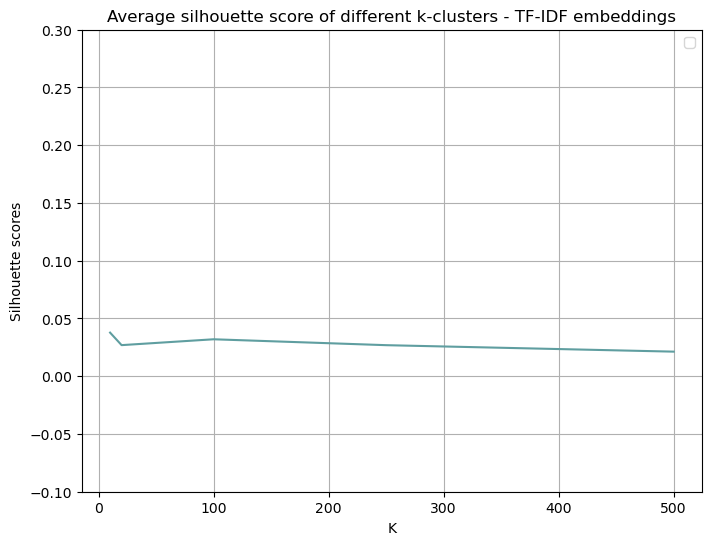

In [51]:
# Plot the average silhouette score for TF-IDF k-clustering
plt.figure(figsize=(8, 6))
print("avg scores",avg_silhouette_scores)
print(list(avg_silhouette_scores.values()))
silhoutte_scores = list(avg_silhouette_scores.values())

plt.plot(k_values, list(avg_silhouette_scores.values()), color="cadetblue")
ax = plt.gca()             
plt.title('Average silhouette score of different k-clusters - TF-IDF embeddings')
plt.xlabel('K')
plt.ylabel('Silhouette scores')
ax.set_ylim([-0.1, 0.3])
plt.legend()
plt.grid(True)
plt.show()

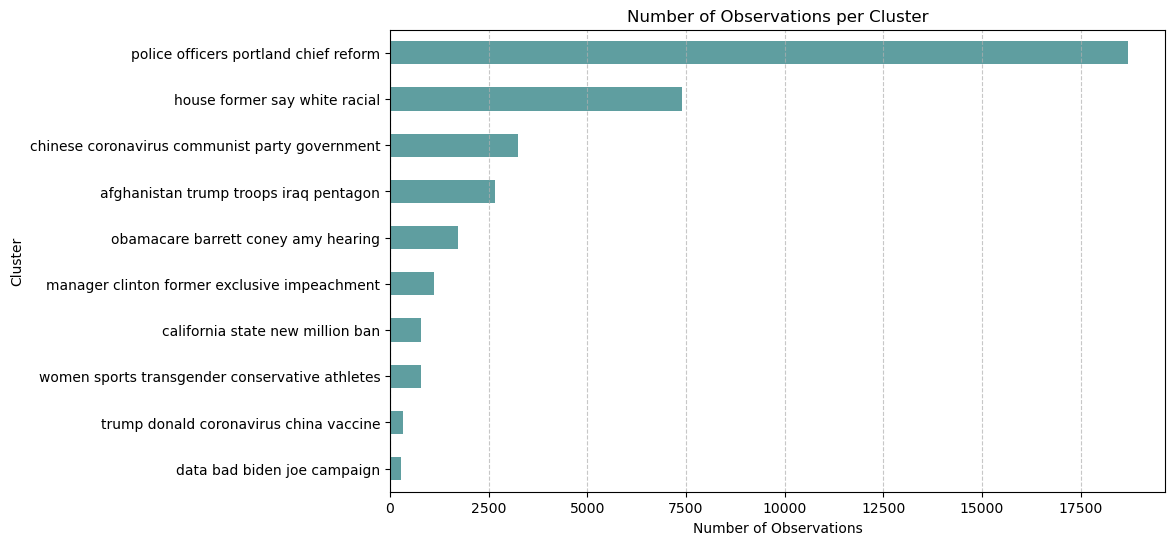

In [63]:
k = 10
feature_names = cv.get_feature_names_out()
topn_features = 5
ordered_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
cluster_counts = embeddings[f"cluster_tf_{k}"].value_counts()
labels = {}
for cluster_num in range(k):
    key_features = [feature_names[index] 
                    for index in ordered_centroids[cluster_num, :topn_features]]
    labels[cluster_num] = " ".join(key_features)

# Sort the clusters by count
cluster_counts = cluster_counts.sort_values()
cluster_counts = cluster_counts[:10]
# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='barh', color='cadetblue')
plt.xlabel('Number of Observations')
plt.ylabel('Cluster')
plt.title('Number of Observations per Cluster')
plt.yticks(range(len(cluster_counts)), [labels[cluster] for cluster in cluster_counts.index])
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
feature_names = cv.get_feature_names_out()
topn_features = 30
ordered_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

# get key features for each cluster
# get articles belonging to each cluster
for k in k_values:
    print('-'*80)
    print(f"features for {k} clusters")
    for cluster_num in range(k):
        key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
        titles = embeddings[embeddings[f'cluster_tf_{k}'] == cluster_num]['title'].values.tolist()
        print('CLUSTER #'+str(cluster_num+1))
        print('Key Features:', key_features)
        print('-'*80)

In [ ]:
from collections import Counter
counter = Counter(kmeans.labels_)
top_clusters = 10

##The following looks really dumb, but for some reason
#If i iterate over the counter object, it's not returning the keys in order.
#So instead oif iterating over the dictionary that is in order, I'll create an ordered list
counter_lst = [(value,key) for key, value in counter.items()]
counter_lst.sort()
counter_lst.reverse()
ordered_clusters = [value for key,value in counter_lst]


#Print first 10 news from top 10 clusters in terms
#of number of articles in cluster
for cluster in ordered_clusters[:10]:
    print('CLUSTER #'+str(cluster+1))
    for row in embeddings[embeddings.cluster_tf_500==cluster][:10].itertuples():
        print("title:",row.title)
    print('-'*80)
